# Loopy: Dealing with Intermediate Results

## Setup code

In [1]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clmath
import pyopencl.clrandom
import loopy as lp

In [2]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [3]:
grid = np.linspace(0, 2*np.pi, 2048, endpoint=False)
h = grid[1] - grid[0]
u = cl.clmath.sin(cl.array.to_device(queue, grid))

## Two kernels: Finite Differences and a Flux

We will implement computing the ODE right-hand side for Burgers' equation:
$$
\frac{\partial u}{\partial t} + \frac{\partial }{\partial x} \left( \frac{u^2}2 \right) = 0,
$$

Now, it is likely that the code fore the derivative is initially separate from the code for the flux function $f(u):=u^2/2$.

For simplicity, we will use central finite differences to build a kernel `fin_diff_knl` to take the derivative:

In [4]:
fin_diff_knl = lp.make_kernel(
    "{[i]: 1<=i<=n}",
    "out[i] = -(f[i+1] - f[i-1])/(2*h)",
    [lp.GlobalArg("out", shape="2+n"), ...])
print(fin_diff_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
h: ValueArg, type: <runtime>
n: ValueArg, type: <runtime>
out: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : i >= 1 and i <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
---------------------------------------------------------------------------
INSTRUCTIONS:
[i]                                  out[i] <- (-1)*(f[i + 1] + (-1)*f[i + -1]) / (2*h)   # insn
---------------------------------------------------------------------------


------------
Next, make the flux kernel as `flux_knl`.
* Use `j` as the loop variable.
* Make sure to declare `f` and `u` to be the right size.

In [5]:
flux_knl = lp.make_kernel(
    "{[j]: 1<=j<=n}",
    "f[j] = u[j]**2/2",
    [
    lp.GlobalArg("f", shape="2+n"),
    lp.GlobalArg("u", shape="2+n"),
    ])
print(flux_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [j] : j >= 1 and j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
[j]                                  f[j] <- u[j]**2 / 2   # insn
---------------------------------------------------------------------------


## Fuse the Kernels

Next, fuse the two kernels together as `fused_knl`, using `lp.fuse_kernels([knl_a, knl_b])`:

In [6]:
#clear
fused_knl = lp.fuse_kernels([fin_diff_knl, flux_knl])

print(fused_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
f: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
h: ValueArg, type: <runtime>
n: ValueArg, type: <runtime>
out: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : i >= 1 and i <= n }
[n] -> { [j] : j >= 1 and j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
j: None
---------------------------------------------------------------------------
INSTRUCTIONS:
[j]                                  f[j] <- u[j]**2 / 2   # insn_0
[i]                                  out[i] <- (-1)*(f[i + 1] + (-1)*f[i + -1]) / (2*h)   # in

Let's take a look at the generated code:

In [7]:
fused_knl = lp.set_options(fused_knl, write_cl=True)
evt, _ = fused_knl(queue, u=u, h=np.float32(1e-1))

#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif
#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel_and_loopy_kernel(__global double *restrict out, __global double *restrict f, float const h, int const n, __global double const *restrict u)
{

  for (int j = 1; j <= n; ++j)
    f[j] = u[j] * u[j] / 2.0;
  for (int i = 1; i <= n; ++i)
    out[i] = -1.0 * (f[i + 1] + -1.0 * f[i + -1]) / (2.0 * h);
}


Next, eliminate the separate loop to compute `f`:

In [8]:
fused_knl = lp.assignment_to_subst(fused_knl, "f")
print(fused_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <runtime>
n: ValueArg, type: <runtime>
out: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [i] : i >= 1 and i <= n }
[n] -> { [j] : j >= 1 and j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i: None
j: None
---------------------------------------------------------------------------
SUBSTIUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------------------
INSTRUCTIONS:
[i]                                  out[i] <- (-1)*(f_subst(i + 1) + (-1)*f_subst(i + -1)) / (2*h)   # insn
---

Again, let's take a look at the generated code:

In [9]:
fused_knl = lp.set_options(fused_knl, write_cl=True)
evt, _ = fused_knl(queue, u=u, h=np.float32(1e-1))

#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif
#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(1, 1, 1))) loopy_kernel_and_loopy_kernel(__global double *restrict out, float const h, int const n, __global double const *restrict u)
{

  for (int i = 1; i <= n; ++i)
    out[i] = -1.0 * (u[i + 1] * u[i + 1] / 2.0 + -1.0 * u[i + -1] * u[i + -1] / 2.0) / (2.0 * h);
}


## Transform the kernel for execution

For easier transformation, renumber the loop to start at 0, using `affine_map_inames(kernel, old_inames, new_inames, equations)`:

In [10]:
#clear
fused0_knl = lp.affine_map_inames(fused_knl, "i", "inew", "inew+1=i")

print(fused0_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <runtime>
n: ValueArg, type: <runtime>
out: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [inew] : inew >= 0 and inew <= -1 + n }
[n] -> { [j] : j >= 1 and j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
inew: None
j: None
---------------------------------------------------------------------------
SUBSTIUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------------------
INSTRUCTIONS:
[inew]                               out[1 + inew] <- (-1)*(f_subst(1 + 1 + inew) + (-1)*f_subs

Now, map the kernel to OpenCL axes:

In [11]:
gpu_knl = lp.split_iname(fused0_knl, "inew", 128, outer_tag="g.0", inner_tag="l.0")
print(gpu_knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel_and_loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
h: ValueArg, type: <runtime>
n: ValueArg, type: <runtime>
out: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
u: GlobalArg, type: <runtime>, shape: (2 + n), dim_tags: (N0:stride:1)
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [inew_outer, inew_inner] : inew_inner >= -128inew_outer and inew_inner <= -1 + n - 128inew_outer and inew_inner >= 0 and inew_inner <= 127 }
[n] -> { [j] : j >= 1 and j <= n }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
inew_inner: l.0
inew_outer: g.0
j: None
---------------------------------------------------------------------------
SUBSTIUTION RULES:
f_subst(j) := u[j]**2 / 2
---------------------------------------------------------------

Finally, precompute the fluxes locally in each workgroup:

In [12]:
precomp_knl = lp.precompute(gpu_knl, "f_subst", "inew_inner", fetch_bounding_box=True)
precomp_knl = lp.tag_inames(precomp_knl, {"j_0_outer": "unr"})
precomp_knl = lp.set_options(precomp_knl, return_dict=True)
evt, _ = precomp_knl(queue, u=u, h=h)

#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif
#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))

__kernel void __attribute__ ((reqd_work_group_size(128, 1, 1))) loopy_kernel_and_loopy_kernel(__global double *restrict out, double const h, int const n, __global double const *restrict u)
{
  __local double f_subst_0[130];

  if (1 + -128 * gid(0) + -1 * lid(0) + n >= 0)
    f_subst_0[lid(0) + 0 * 128] = u[128 * gid(0) + lid(0) + 0 * 128] * u[128 * gid(0) + lid(0) + 0 * 128] / 2.0;
  if (
      -127 + -128 * gid(0) + -1 * lid(0) + n >= 0
      && 1 + -1 * lid(0) >= 0
    )
    f_subst_0[lid(0) + 1 * 128] = u[128 * gid(0) + lid(0) + 1 * 128] * u[128 * gid(0) + lid(0) + 1 * 128] / 2.0;
  barrier(CLK_LOCAL_MEM_FENCE) /* for f_subst_0 (insn depends on f_subst) */;
  if (-1 + -128 * gid(0) + -1 * lid(0) + n >= 0)
    out[1 + lid(0) + gid(0) * 128] = -1.0 * (f_subst_0[2 + lid(0)] + -1.0 * f_subst_0[lid(0)]) / (2.0 * h);
}


## Run the PDE

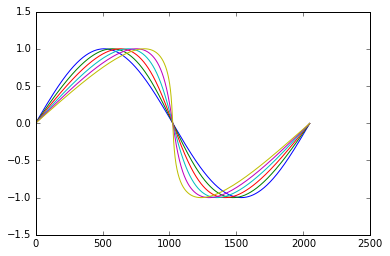

In [16]:
import matplotlib.pyplot as pt

# Forward Euler on a hyperbolic problem: terrible idea. Oh well.

dt = 0.2*h
u = cl.clmath.sin(cl.array.to_device(queue, grid))
for i in range(1800):
    _, result_dict = precomp_knl(queue, u=u, h=h)
    out = result_dict["out"]
    out[0] = out[-1] = 0
    u = u + dt*out
    
    if i % 300 == 0:
        pt.plot(u.get())